## 1. Problem Statement
- Air pollution is a critical environmental issue that directly impacts public health and quality of life. One of the major pollutants, PM2.5 (particulate matter with a diameter less than 2.5 micrometers), poses serious health risks due to its ability to penetrate deeply into the lungs. 
- Understanding and forecasting the concentration of PM2.5 is crucial for timely intervention, enabling public authorities to issue warnings, and helping individuals make informed decisions regarding outdoor activities.
- The goal of this project is to build a time series forecasting model that accurately predicts PM2.5 concentrations in the air.


## 2. Import data and necesssary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arff
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler

#stats models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from sklearn.metrics import mean_squared_error
from arch import arch_model


# PMDARIMA
import pmdarima as pm
from pmdarima import auto_arima



In [2]:
# Load the ARFF file
with open(r'C:\Users\hp\data_science\time_series\dataset.arff', 'r') as f:
    dataset = arff.load(f)

# Extract the data and attribute names
data = dataset['data']
attribute_names = [attr[0] for attr in dataset['attributes']]

# Create a pandas DataFrame
data = pd.DataFrame(data, columns=attribute_names)

#Make a copy
data_original = data.copy()

In [3]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


#### Basic EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


In [5]:
data.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,10122.116943,1.177198,3.448707,8.800102,6.922195,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [6]:
# Categorical columns
cat_cols = data.select_dtypes(include='object').columns
cat_cols

Index(['wd', 'station'], dtype='object')

In [7]:
#Numerical columns
num_cols = data.select_dtypes(include ='number').columns
num_cols

Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'],
      dtype='object')

In [8]:
#Check for missingness
data.isnull().sum()

No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

#### Data Preprocessing and Feature Engineering

In [9]:
# Add date column
data['Date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

#Set 'Date' as the index
data.set_index('Date', inplace=True)

In [10]:
# Add time based features
data['week'] = data.index.isocalendar().week
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [11]:
# Handling missing values
# Interpolation is chosen because it respects the temporal structure of the data
data.interpolate(method='linear', inplace =True)

In [12]:
#Drop unnecessary columns
data.drop(columns=['No', 'year', 'month', 'day', 'hour'], axis=1, inplace=True)

In [13]:
#Create lagged features for 'PM2.5' column

lags = [1, 2, 3, 7, 14]
for lag in lags:
    data[f'PM2.5_lag_{lag}'] = data['PM2.5'].shift(lag)


In [14]:
# Create rolling statistics features 
windows = [7,14,30]
features = ['PM2.5', 'TEMP', 'NO2', 'O3'] 

for feature in features:
    for window in windows:
        data[f'{feature}_rolling_mean_{window}'] = data[feature].rolling(window=window).mean()
        data[f'{feature}_rolling_std_{window}'] = data[feature].rolling(window=window).std()
        

In [15]:
data.dropna(inplace=True)

In [16]:
# Apply Log Transformation to stabilize variance
#data['PM2.5_log'] = np.log(data['PM2.5'])

In [17]:
# Resample the df to daily frequency
num_cols = data.select_dtypes(include=np.number).columns
df = data[num_cols].resample('D').mean()


In [18]:
#View the data
# plt.figure(figsize=(20,5))
# plt.plot(df['PM2.5'])

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

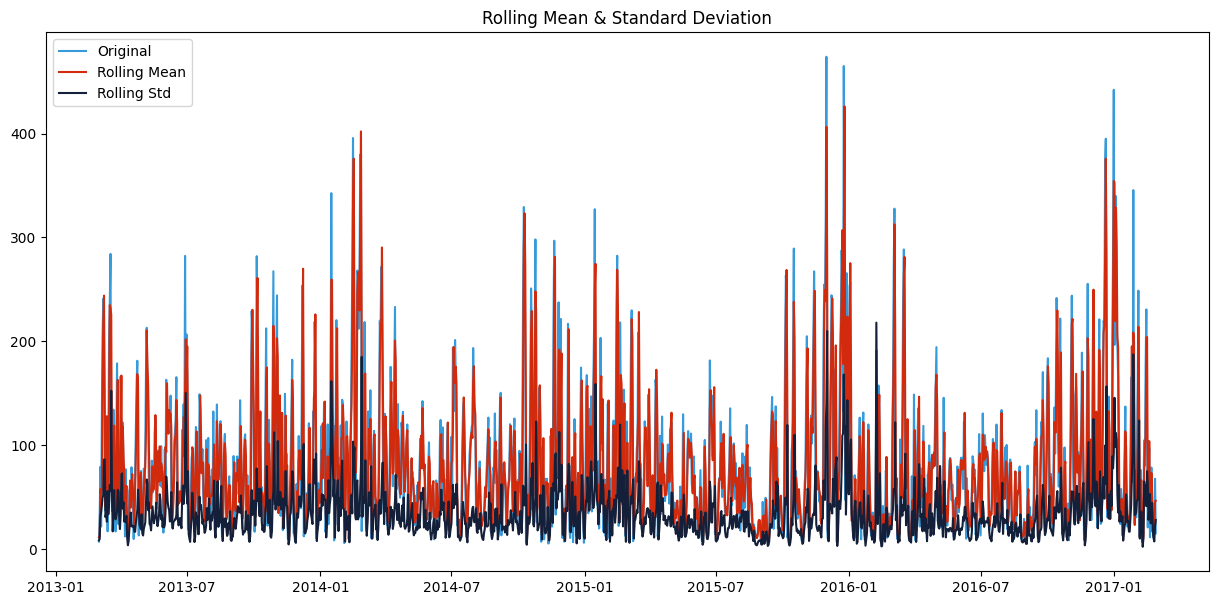

In [19]:
#Visualize rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["PM2.5"], color='#379BDB', label='Original')
plt.plot(df["PM2.5_rolling_mean_30"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["PM2.5_rolling_std_30"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

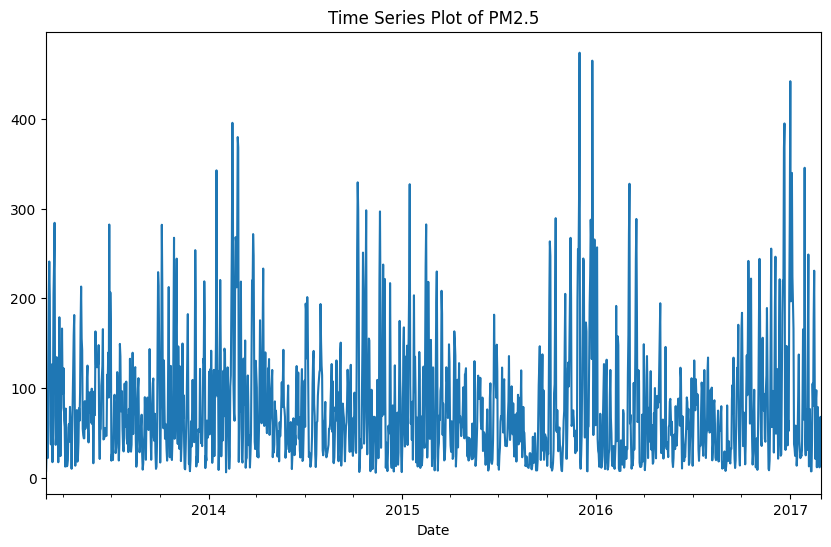

In [20]:
#Visual inspection of seasonal fluctuations
df['PM2.5'].plot(figsize=(10,6), title='Time Series Plot of PM2.5')
plt.show()

- Magnitude of fluctuations (seasonality) does not appear to scale proportionally with the level of the time series. Therefore an additive model is to be used.

<Figure size 1200x800 with 0 Axes>

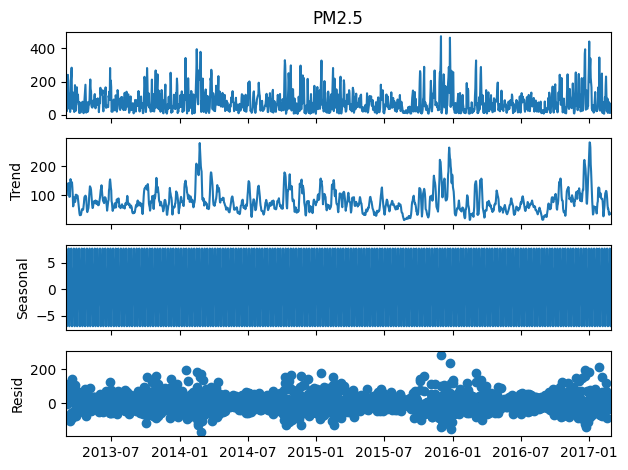

In [21]:
# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df['PM2.5'], model='additive', period=7)

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

- No overall long-term trend but there are periods of higher and lower average concentrations.
- Seasonal component that appears to oscillate with a consistent frequency.
- Residual: unexplained variation after accounting for trend and seasonality.

#### Stationarity

In [22]:
#Test for stationarity using adfuller test
result = adfuller(df['PM2.5'].dropna(),autolag='AIC')
result


(-17.440333263789267,
 4.7132432470426236e-30,
 2,
 1458,
 {'1%': -3.434843038681996,
  '5%': -2.8635243777871286,
  '10%': -2.56782646544019},
 15540.596193207264)

- P Value is less than 0.05 and ADF statistic is less than the critical values indicating Stationary

In [23]:
#Calculate train index
train_size = int(len(df) * 0.8)

#Split the data based on data index (to preserve temporal order)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [24]:
print(train.shape, test.shape)

(1168, 43) (293, 43)


In [25]:
train['PM2.5'].interpolate(method='linear', inplace=True) 

In [26]:
print(train.shape, test.shape)

(1168, 43) (293, 43)


#### Correlation

Text(0.5, 1.0, 'ACF in  PM2.5 Time Series')

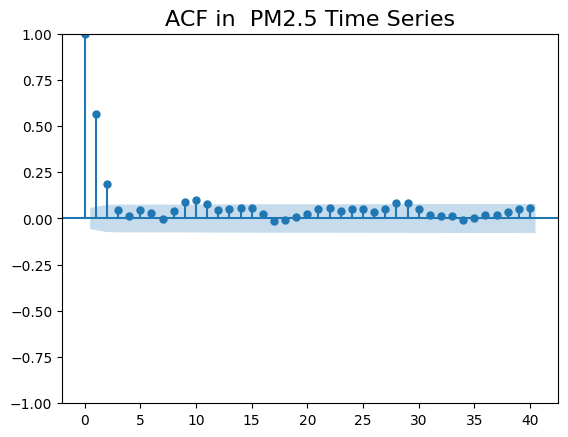

In [27]:
#ACF
plot_acf(train['PM2.5'][:-1], alpha=0.05, lags=40)
plt.title('ACF in  PM2.5 Time Series', fontsize = 16)

- There's a slow decay in autocorrelation, particularly in the first few lags
- q order= 2

Text(0.5, 1.0, 'PACF in  PM2.5 Time Series')

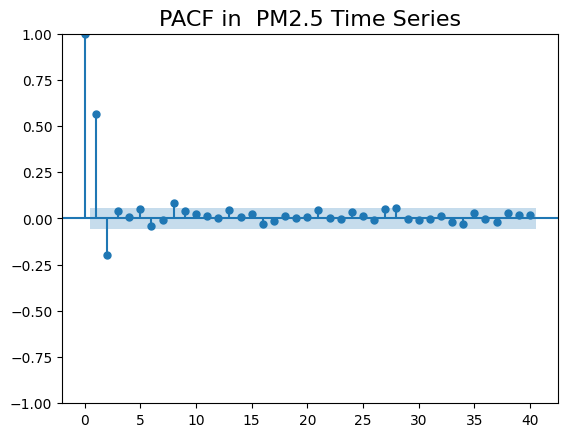

In [28]:
#PACF
plot_pacf(train['PM2.5'][:-1], alpha=.05, lags=40)
plt.title('PACF in  PM2.5 Time Series', fontsize = 16)

- Higher-order AR terms are not necessary as the significant autocorrelation is largely captured by the first lag.
- p order = 2

#### ARIMA Model

In [29]:
# Fit ARIMA model
arima_model = ARIMA(train['PM2.5'], order=(2, 0, 2))
arima_result = arima_model.fit()

In [30]:
# ARIMA Predictions
start, end = len(train), len(train) + len(test) - 1
arima_predictions = arima_result.predict(start=start, end=end)
arima_predictions

2016-05-12    132.349550
2016-05-13     99.674361
2016-05-14     85.429508
2016-05-15     81.079704
2016-05-16     80.187393
                 ...    
2017-02-24     80.283336
2017-02-25     80.283336
2017-02-26     80.283336
2017-02-27     80.283336
2017-02-28     80.283336
Freq: D, Name: predicted_mean, Length: 293, dtype: float64

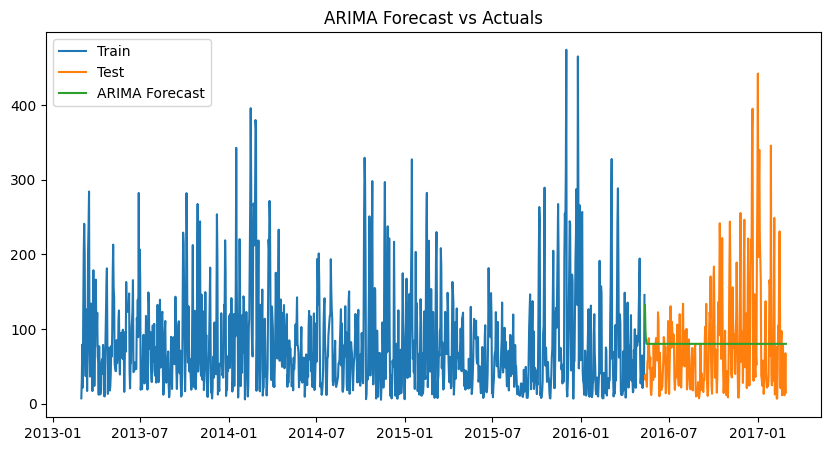

In [31]:
# Plot the predictions against actual values
plt.figure(figsize=(10, 5))
plt.plot(train['PM2.5'], label='Train') 
plt.plot(test['PM2.5'], label='Test') 
plt.plot(arima_predictions, label='ARIMA Forecast')
plt.legend(loc='upper left')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

- ARIMA model does not capture the seasonality present in the test data.

In [32]:
arima_error = mean_squared_error(test['PM2.5'], arima_predictions, squared=False)
arima_error

70.31248436058087

### SEASONAL MODELS

In [33]:
#Obtain recommended orders
pm.auto_arima(train['PM2.5'], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1168
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 7)   Log Likelihood               -6309.304
Date:                            Wed, 02 Oct 2024   AIC                          12628.607
Time:                                    11:59:27   BIC                          12653.922
Sample:                                03-01-2013   HQIC                         12638.156
                                     - 05-11-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     54.1489      4.956     10.927      0.000      44.436      63.862
ar.L1          0.3599      0.034     10.552      0.000       0.293       0.427
ma.L1          0.3278      0.039      8.405      0.000       0.251       0.404
ar.S.L7       -0.0536      0.025     -2.152      0.031      -0.102      -0.005
sigma2      2879.8748     76.877     37.461      0.000    2729.200    3030.550
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               853.50
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.79
Prob(H) (two-sided):                  0.96   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Suggested order: SARIMAX(1, 0, 1)x(1, 0, [], 7)
- D=1 used because the data shows stable seasonal component over time.

#### SARIMA

In [34]:

# Fit SARIMA model
sarima_model = SARIMAX(train['PM2.5'], order=(1,0,1), seasonal_order=(1,1,0,7))
sarima_result = sarima_model.fit()

# SARIMA Predictions
sarima_predictions = sarima_result.predict(start=start, end=end)

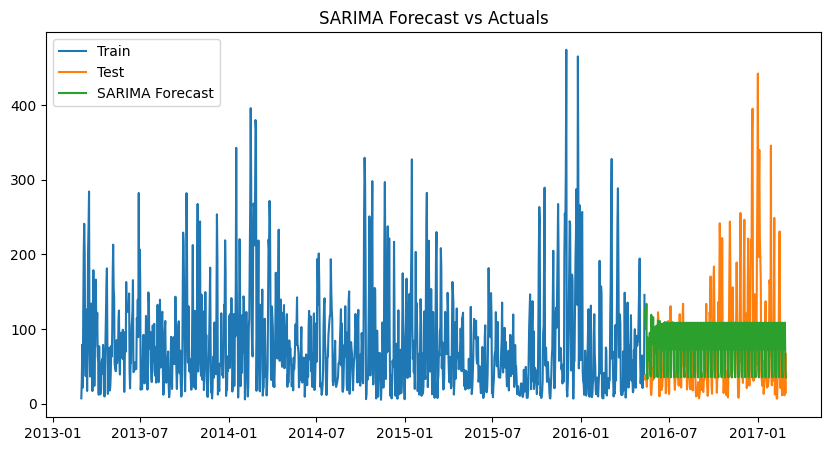

In [35]:
# Plot the predictions against actual values
plt.figure(figsize=(10, 5))
plt.plot(train['PM2.5'], label='Train')
plt.plot(test['PM2.5'], label='Test')
plt.plot(sarima_predictions, label='SARIMA Forecast')
plt.legend(loc='upper left')
plt.title('SARIMA Forecast vs Actuals')
plt.show()

In [36]:
sarima_error = mean_squared_error(test['PM2.5'], sarima_predictions, squared=False)
sarima_error

74.32621375812852

#### SARIMAX

In [37]:
# Exogenous features for SARIMAX
exog_features = ['NO2', 'CO', 'O3']
train_exog = train[exog_features]
test_exog = test[exog_features]


In [38]:
# Fit SARIMAX model
sarimax_model = SARIMAX(train['PM2.5'], order=(1,0,1), seasonal_order=(1,1,0,7), exog=train_exog)
sarimax_result = sarimax_model.fit()

# SARIMAX Predictions
sarimax_predictions = sarimax_result.predict(start=start, end=end, exog=test_exog).rename('SARIMAX Predictions')


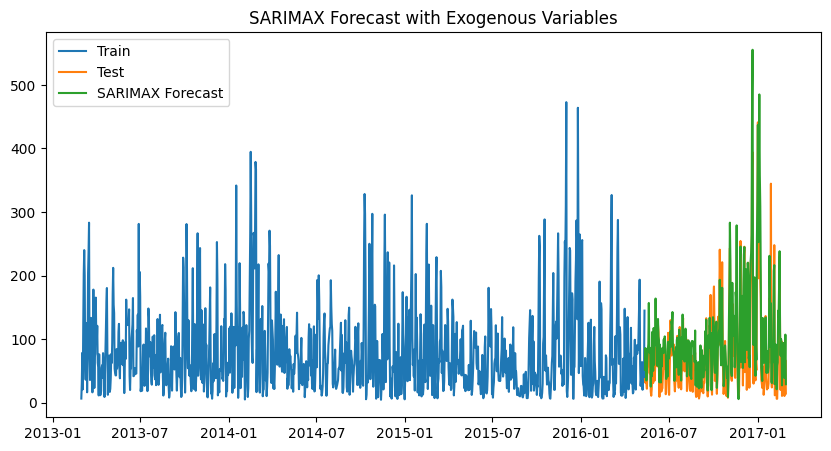

In [39]:
# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(train['PM2.5'] - 1, label='Train')  
plt.plot(test['PM2.5'] - 1, label='Test')  
plt.plot(sarimax_predictions, label='SARIMAX Forecast')
plt.legend(loc='upper left')
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.show()


- Captures overall trend
- Forecast overestimates PM2.5 levels in some parts of the test period

In [40]:
sarimax_error = mean_squared_error(test['PM2.5'], sarimax_predictions, squared=False)
sarimax_error

40.530643954569314

### MODEL EVALUATION FOR THE BEST MODEL: SARIMAX

<function matplotlib.pyplot.show(close=None, block=None)>

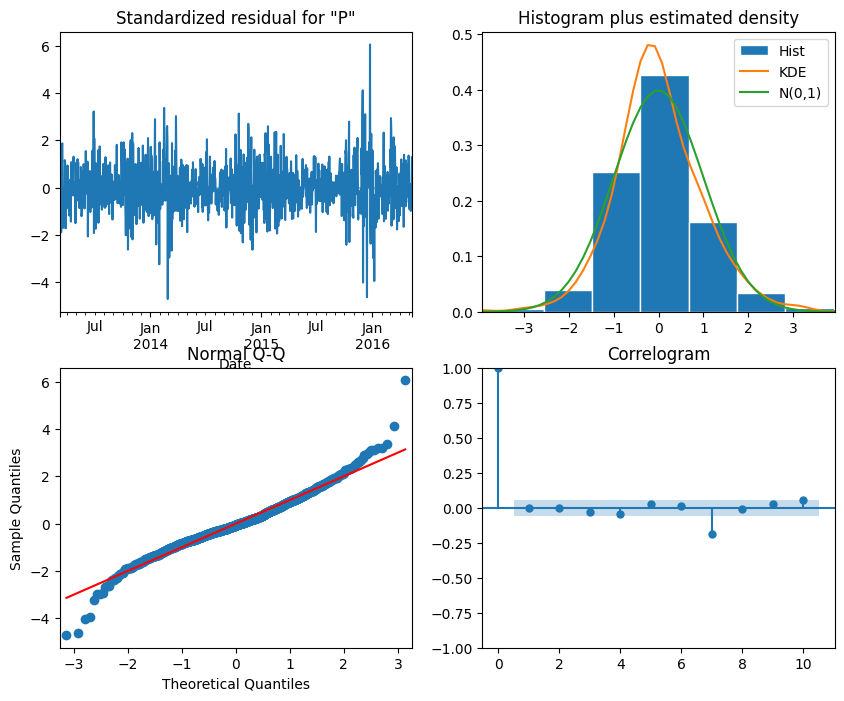

In [41]:
sarima_result.plot_diagnostics(figsize=(10,8))
plt.show

-HISTOGRAM

    - The KDE shows that the residuals are somewhat close to a normal distribution but sligtly skewed, especially toward the left.

-Q-Q PLOT

    - Most of the points lie along the red line, indicating that the residuals follow a normal distribution reasonably well, though there are deviations at both ends

-CORRELOGRAM

    - Most autocorrelations are near zero, suggesting that the residuals are not strongly autocorrelated.